In [1]:
import gww_gis_tools.merge_gis.sewer_helpers as sh
import gww_gis_tools.trace_gis.trace_sewer as ts

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from tqdm import tqdm
from tqdm.auto import tqdm

tqdm.pandas()

In [ ]:
layer = "pipes"
pipes_tab_file = sh.Config.output_template.format(id=layer)
pipes_gdf = gpd.read_file(pipes_tab_file)

In [ ]:
g_up = ts.Graph(ts.DIRECTION.U).from_gdf(pipes_gdf)
g_down = ts.Graph(ts.DIRECTION.D).from_gdf(pipes_gdf)

In [ ]:
layer = "nodes"
nodes_tab_file = sh.Config.output_template.format(id=layer)
nodes_gdf = gpd.read_file(nodes_tab_file)

In [ ]:
def classify(row):
    in_count = row.in_count
    out_count = row.out_count

    # if in_count >= 1 and out_count == 1:
    #     node = 'x-1'
    # elif in_count == 0 and out_count == 1:
    #     node = 'top'
    # elif in_count == 1 and out_count == 2:
    #     node = 'bif-p'
    # elif in_count == 0 and out_count == 2:
    #     node = 'd-top'
    # elif out_count > 2:
    #     node = 'x-X'
    # elif out_count == 0:
    #     node = 'x-0'
    # else:
    #     node = 'else'

    return f"{in_count}-{out_count}"


def approx_equal(a, b, threshold=0.1):
    return abs(a - b) < threshold

In [ ]:
g_up = ts.Graph(ts.DIRECTION.U).from_gdf(pipes_gdf)
g_down = ts.Graph(ts.DIRECTION.D).from_gdf(pipes_gdf)

nodes_gdf["in_count"] = nodes_gdf["NODE_ID"].progress_apply(
    lambda x: len(g_up.nodes.get(x, []))
)
nodes_gdf["out_count"] = nodes_gdf["NODE_ID"].progress_apply(
    lambda x: len(g_down.nodes.get(x, []))
)
print("in_counts:", nodes_gdf["in_count"].unique())
print("out_counts:", nodes_gdf["out_count"].unique())

nodes_gdf["class"] = nodes_gdf.progress_apply(classify, axis=1)
print("unique classes:", nodes_gdf["class"].nunique())

outfalls = nodes_gdf[nodes_gdf["out_count"] == 0]
print('number of "outfalls":', len(outfalls))

nodes_gdf[["NODE_ID", "class"]].to_csv(
    r"C:\Users\holmest1\Greater Western Water\IP - Spatial - Documents\Input\2. GWW GIS Exports\Existing Assets\Merged Regions\Sewer\node_class.csv"
)

100%|██████████| 163538/163538 [00:00<00:00, 583665.26it/s]


in_counts: [0 1 2 3 4 8 5]
out_counts: [0 1 2 3 4]


100%|██████████| 163538/163538 [00:03<00:00, 44993.86it/s]


unique classes: 23
number of "outfalls": 5044


In [ ]:
nodes_lookup = nodes_gdf.set_index("NODE_ID")


def add_data(pipe):
    flows_downhill = pipe.START_INVELEV > pipe.END_INVELEV
    abs_drop = abs(pipe.START_INVELEV - pipe.END_INVELEV)

    start_node = pipe.START_NODE
    if not start_node in nodes_lookup.index:
        start_node_found = False
        start_node_type = "else"
        start_node_depth = 0
        start_node_floor = 0
        start_node_match = False
        start_node_class = "else"
    else:
        start_node_found = True
        start_node_type = nodes_lookup.loc[start_node, "NODE_TYPE"]
        start_node_depth = nodes_lookup.loc[start_node, "NODE_DEPTH"]
        start_node_floor = (
            nodes_lookup.loc[start_node, "NODE_COVELEV"] - start_node_depth
        )
        start_node_match = (
            pipe.START_COVELEV == nodes_lookup.loc[start_node, "NODE_COVELEV"]
        )
        start_node_class = nodes_lookup.loc[start_node, "class"]

    end_node = pipe.END_NODE
    if not end_node in nodes_lookup.index:
        end_node_found = False
        end_node_type = "else"
        end_node_depth = 0
        end_node_floor = 0
        end_node_match = False
        end_node_class = "else"
    else:
        end_node_found = True
        end_node_type = nodes_lookup.loc[end_node, "NODE_TYPE"]
        end_node_depth = nodes_lookup.loc[end_node, "NODE_DEPTH"]
        end_node_floor = nodes_lookup.loc[end_node, "NODE_COVELEV"] - end_node_depth
        end_node_match = pipe.END_COVELEV == nodes_lookup.loc[end_node, "NODE_COVELEV"]
        end_node_class = nodes_lookup.loc[end_node, "class"]

    if (
        start_node_found
        and end_node_found
        and not start_node_match
        and not end_node_match
    ):
        transposed_nodes = (
            pipe.END_COVELEV == nodes_lookup.loc[start_node, "NODE_COVELEV"]
        ) and (pipe.START_COVELEV == nodes_lookup.loc[end_node, "NODE_COVELEV"])
    else:
        transposed_nodes = False

    return (
        flows_downhill,
        start_node_found,
        start_node_type,
        start_node_depth,
        start_node_floor,
        start_node_match,
        start_node_class,
        end_node_found,
        end_node_type,
        end_node_depth,
        end_node_floor,
        end_node_match,
        end_node_class,
        transposed_nodes,
    )


new_cols = [
    "flows_downhill",
    "start_node_found",
    "start_node_type",
    "start_node_depth",
    "start_node_floor",
    "start_node_match",
    "start_node_class",
    "end_node_found",
    "end_node_type",
    "end_node_depth",
    "end_node_floor",
    "end_node_match",
    "end_node_class",
    "transposed_nodes",
]

pipes_gdf[new_cols] = pipes_gdf.progress_apply(add_data, axis=1, result_type="expand")

100%|██████████| 161207/161207 [00:37<00:00, 4286.98it/s]


In [ ]:
good_class_mask = (pipes_gdf["start_node_class"].str.endswith("-1")) & (
    pipes_gdf["end_node_class"].str.endswith("-1")
)

standard_node_types = [
    "AP_ENDOFPIPE",
    "AP_ACCESSSHAFT",
    "AP_CHAMBERED",
    "AP_CHANGEOFGRADE",
    "AP_ENDOFPIPE",
    "AP_ERSPITMANHOLE",
    "AP_GASCHECK",
    "AP_INSPECTIONSHAFT",
    "AP_JUNCTIONCHAMBER",
    "AP_MAINTCHAMBER",
    "AP_PIPEJUNCTION",
    "AP_SIPHONENTRY",
    "AP_SIPHONEXIT",
    "AP_STANDARD",
    "AP_VACCOLLECTIONPIT",
    "AP_WALKIN",
    "BEND",
    "DEPTHCHANGE",
    "INSPECTION_SHAFT",
    "JUNCTION",
    "MAINTENANCE CHAMBER",
    "MAINTENANCE_SHAFT",
    "MANHOLE_PUB",
    "MANHOLE_PVT",
    "POLY_PIT",
    "PRIVATE_BEND",
    "STANDARD_MANHOLE",
]

standard_node_where = pipes_gdf["start_node_type"].isin(
    standard_node_types
) & pipes_gdf["end_node_type"].isin(standard_node_types)

print(pipes_gdf.shape)
print(pipes_gdf[~good_class_mask].shape)
print(pipes_gdf[standard_node_where].shape)
print(pipes_gdf[standard_node_where & ~good_class_mask].shape)

pipes_gdf[standard_node_where & ~good_class_mask][
    ["start_node_class", "end_node_class"]
].value_counts().reset_index(name="count")

(161207, 32)
(7770, 32)
(146419, 32)
(6020, 32)


,start_node_class,end_node_class,count
0,1-2,1-1,757
1,1-2,2-1,599
2,1-1,1-2,435
3,0-2,1-1,407
4,0-2,2-1,345
...,...,...,...
109,1-4,2-0,1
110,1-4,2-1,1
111,2-3,1-0,1
112,2-3,2-0,1


## Situation 1 
Reversed pipe between nodes with two connected pipes each. Results in node classes 0-2 -> 2-0. 

Correct situation, apparently, should be 1-1 -> 1-1. Validated by transposed node cover levels. 

Side note: Raises question about correct order of cover levels?

C:\Users\holmest1\AppData\Local\Temp\3\ipykernel_28436\3940152328.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bool_to_int = lambda x: x.replace({True: 1, False: 0})


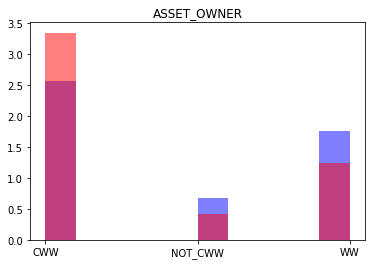

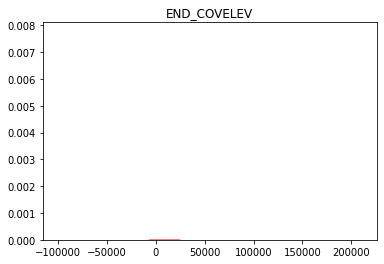

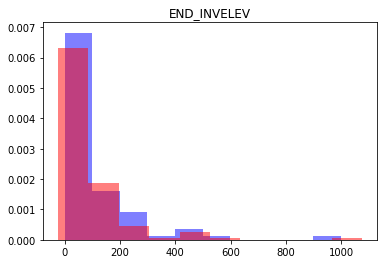

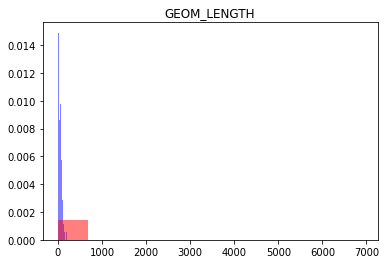

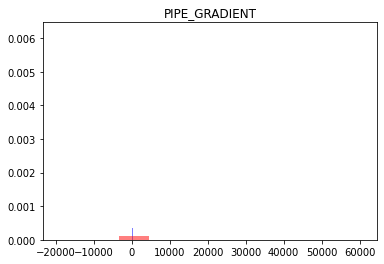

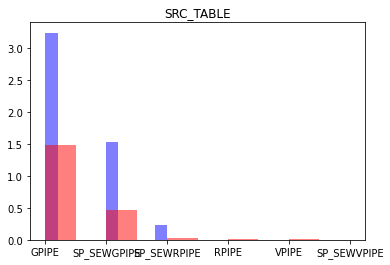

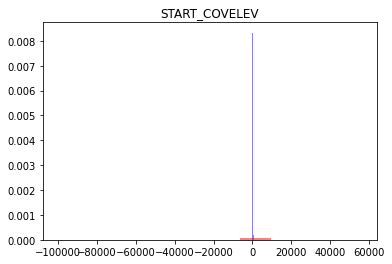

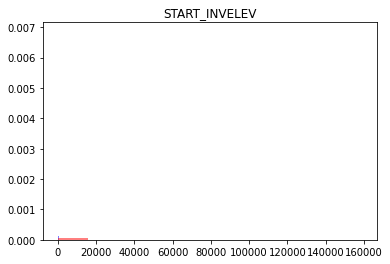

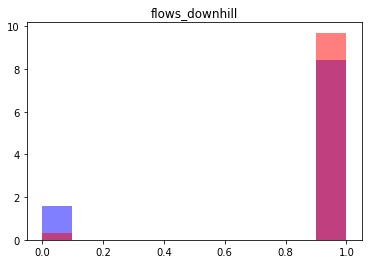

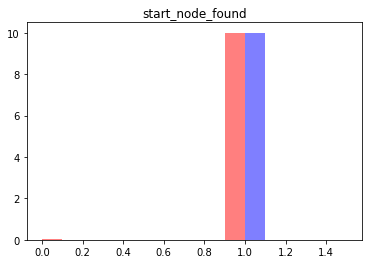

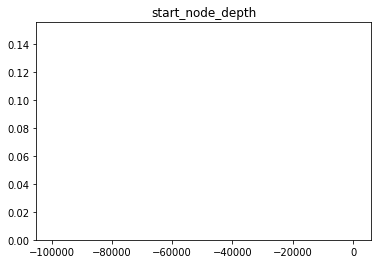

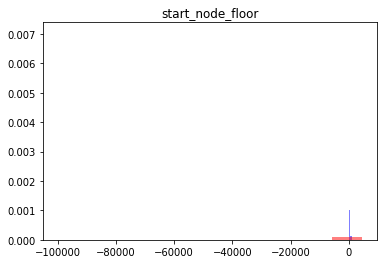

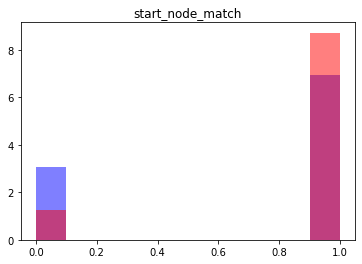

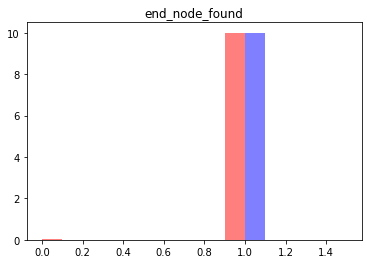

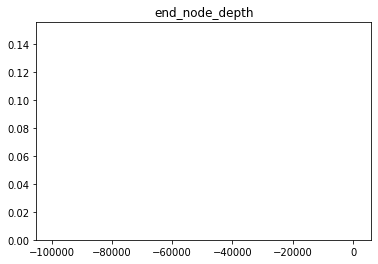

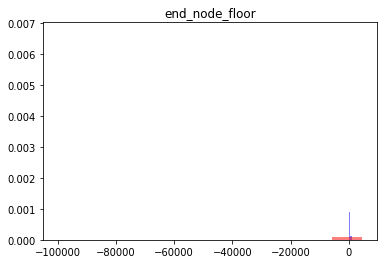

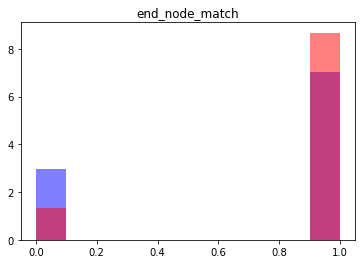

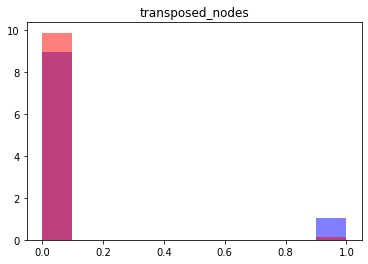

In [ ]:
sit1 = pipes_gdf[
    (pipes_gdf["end_node_class"] == "2-0") & (pipes_gdf["start_node_class"] == "0-2")
]

for c in pipes_gdf.columns:
    bool_to_int = lambda x: x.replace({True: 1, False: 0})
    if (pipes_gdf[c].nunique() <= 15) or sit1[c].dtype == float:
        fig, ax = plt.subplots()
        ax.hist(bool_to_int(sit1[c]), color="blue", density=True, alpha=0.5)
        ax.hist(bool_to_int(pipes_gdf[c]), color="red", density=True, alpha=0.5)
        ax.set_title(c)

In [ ]:
reversed_pipes = {}

In [ ]:
# confirmed with transposed nodes
new_pipes = {
    id: "sit1, transposed depth"
    for id in sit1[sit1["transposed_nodes"] == True]["PIPE_ID"].values
}
print(len(new_pipes))
reversed_pipes.update(new_pipes)

# not confirmed with transposed nodes
new_pipes = {
    id: "sit1, not transposed depth"
    for id in sit1[sit1["transposed_nodes"] == False]["PIPE_ID"].values
}
print(len(new_pipes))
reversed_pipes.update(new_pipes)

9
79


## Situation 2
Reversed pipe between nodes. One has two connected pipes, the other has three connected pipes. Results in node classes 0-2 -> 3-0. 

Correct situation, apparently, should be 2-1 -> 1-1. Validated by transposed node cover levels. 

Side note: Raises question about correct order of cover levels?

In [ ]:
def swap_nodes(row):
    if row.PIPE_ID in reversed_pipes:
        return sh.Corrections.swap_nodes(row)
    else:
        return row


pipes_gdf.progress_apply(lambda x: swap_nodes(x), axis=1)
print(len(reversed_pipes))

g_up = ts.Graph(ts.DIRECTION.U).from_gdf(pipes_gdf)
g_down = ts.Graph(ts.DIRECTION.D).from_gdf(pipes_gdf)

nodes_gdf["in_count"] = nodes_gdf["NODE_ID"].progress_apply(
    lambda x: len(g_up.nodes.get(x, []))
)
nodes_gdf["out_count"] = nodes_gdf["NODE_ID"].apply(
    lambda x: len(g_down.nodes.get(x, []))
)
print("in_counts:", nodes_gdf["in_count"].unique())
print("out_counts:", nodes_gdf["out_count"].unique())

nodes_gdf["class"] = nodes_gdf.progress_apply(classify, axis=1)
print("unique classes:", nodes_gdf["class"].nunique())

outfalls = nodes_gdf[nodes_gdf["out_count"] == 0]
print('number of "outfalls":', len(outfalls))

nodes_gdf[["NODE_ID", "class"]].to_csv(
    r"C:\Users\holmest1\Greater Western Water\IP - Spatial - Documents\Input\2. GWW GIS Exports\Existing Assets\Merged Regions\Sewer\node_class.csv"
)

100%|██████████| 161207/161207 [00:16<00:00, 10061.69it/s]


88


100%|██████████| 163538/163538 [00:00<00:00, 672094.37it/s]


in_counts: [0 1 2 3 4 8 5]
out_counts: [0 1 2 3 4]


100%|██████████| 163538/163538 [00:03<00:00, 47785.60it/s]


unique classes: 23
number of "outfalls": 5044


In [ ]:
tracer = ts.Trace(g_down)
start_nodes = pipes_gdf.START_NODE.unique().tolist()

outfalls_encountered = []
path_lengths = []

for start_node in tqdm(start_nodes):
    tr = tracer.trace(start_node)
    outfalls_encountered.extend(tr.end_of_path_nodes)
    path_lengths.append(len(tr.nodes) - 1)

print("number of start nodes/traces: ", len(start_nodes))
print("number of encounters with an outfall: ", len(outfalls_encountered))
print("number of unique outfalls: ", len(set(outfalls_encountered)))
print("average path length: ", sum(path_lengths) / len(path_lengths))

  0%|          | 532/159020 [02:56<14:34:19,  3.02it/s]


KeyboardInterrupt: 